# Introduction

First, I reproduced the axon-propagation result but with some changes that make it more biologically robust (detailed below). But this is boring. 

Second, for fun, I use the idea of binary/trinary coding in an adaption of Larry Abbott's FORCE learning [0]. 

The premise here is to make sense of world where the neural code is **strictly** binary but organisms must still make smooth regular movements. These two worlds seem, naively, to contradict. I started with FORCE really out of curiosity, and because of all the learning rules I know it was the least likely to work! 

I'm surprised and pleased that my adaption, BINARYFORCE, works so well, after all.

While FORCE is not biologically plausible (as implemented here), two of its keys ideas do have theoretical and empirical support. FORCE uses the idea of high dimensional random (non-)linear encoding tied to linear decoding, which is found in all the 'echo state' and 'liquid state' learning systems (google for more) and which seem to be supported by data from visual areas[1], and motor cortex [3], among other areas [5]. Separately, Nengo/NEF used a similar(-ish) technique to make SPAUN [4].

### Relevant Papers

* [0] **Original FORCE learning paper**
    * Sussillo D, Abbott LF (2009). [Generating coherent patterns of activity from chao*tic neural networks](http://dx.doi.org/10.1016/j.neuron.2009.07.018). *Neuron*. 63(4):544-57

* [1] **Application of recurrent neural network learning to model dynamics in primate visual cortex**
    * Mante V, Sussillo D, Shenoy KV, Newsome WT (2013). [Context-dependent computation by recurrent dynamics in prefrontal cortex](http://dx.doi.org/10.1038/nature12742). *Nature*. 503(7474):78-84.
       
* [2] **How recurrent neural networks respond to sinusoidal input**
    * Rajan K, Abbott LF, Sompolinsky H (2010). [Stimulus-Dependent Suppression of Chaos in Recurrent Neural Networks](http://neurotheory.columbia.edu/~larry/RajanNIPS10.pdf). *Phys. Rev. E* 82:011903.
    
* [3] **Motor movement and dynamics** 
    * Shenoy, Sahani, and Churchland (2013) [Cortical Control of Arm Movements: A Dynamical Systems Perspective](http://www.annualreviews.org/doi/pdf/10.1146/annurev-neuro-062111-150509) *Annual Review of Neuroscience* Vol. 36: 337-359

* [4] **SPAUN, a real big functional 'brain' model**
    * Eliasmith et al (2012) [A Large-Scale Model of the Functioning Brain](http://www.sciencemag.org/content/338/6111/1202.full.pdf) *Science* 338(6111):1202-1205

* [5] **Reservoir computing and reinforcement learning**
     * Bernacchia A, Seo H, Lee D, Wang X-J (2011) [A reservoir of time constants for memory traces in cortical neurons](http://www.cns.nyu.edu/wanglab/publications/pdf/bernacchia.nn2011.pdf) *Nature Neurosci.*, 14: 366-372 

# Results

## Tee's axon (modified)

We model the axon as a set of passive cables intrupted by an active amplfication system, i.e., the Nodes of Ravier. Unlike Tee's intial construction I assume the noise contribution of the NoR, which is ultimatly provdied by stereotyped the action potential, is nearly nill. This, of course, about halves the effect Tee reported, but the overall finding is still more than robust enough. Tee's argument seems to hold.

Making the construction more realistic (but not altering the end result) I bind the intracellular voltage to the -0.07 to 0.04. Values outside this range are clipped into it. (It'd be better to implement a homeostatic 'leak' current rather than clip, but this will do for a first pass).

In [1]:
import pylab as plt
import numpy as np
%matplotlib inline
from __future__ import division
from scipy.integrate import odeint,ode
from numpy import zeros,ones,eye,tanh,dot,outer,sqrt,linspace,cos,pi,hstack,zeros_like,abs,repeat
from numpy.random import uniform,normal,choice
%config InlineBackend.figure_format = 'retina'

Setup the `axon` code

In [2]:
from numpy.random import normal
from numpy import asarray
def axon(a0, n, sigma_l, sigma_b, min_v=-0.07, max_v=-0.04):
    """A Tee-type axon. 
    
    An intial voltage a0 is sequentially corrupted
    by additive noise even when signal boosting
    is perfect.
    
    Params
    ------
    a0 : scalar
        The initial voltage
    n : scalar
        Number of nodes
    sigma_l : scalar
        Std dev of the leak
    sigma_b : scalar
        Std dev of the boost (should be very small)
    min_v : scalar 
        Min voltage (-0.07 mV)
    max_v : scalar
        Max volate (-0.04 mV)
    """
    
    if a0 > max_v:
        raise ValueError("a0 must be smaller than {0}".format(max_v))
    if a0 < min_v:
        raise ValueError("a0 must be larger than {0}".format(min_v))
        
    ax = [a0, ]
    for i in range(1, n+1):
        ax.append(
            ax[-1] + 
            normal(loc=0.0, scale=sigma_l, size=1)[0] + 
            normal(loc=0.0, scale=sigma_b, size=1)[0]
        )
    
    ax = asarray(ax)
    
    # Clip
    ax[ax < min_v] = min_v
    ax[ax > max_v] = max_v
    
    return ax

* Single example axon, how does a0 (intial volage) drift with the number of nodes?

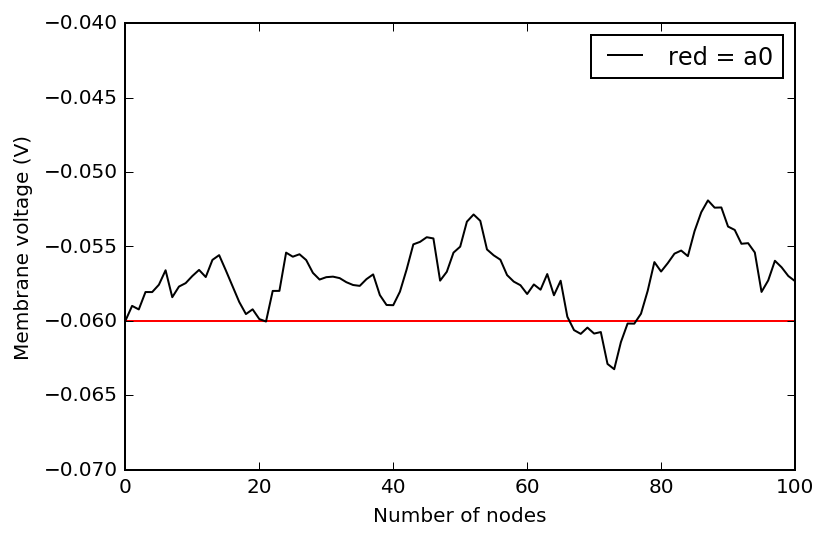

In [3]:
a0 = -0.06 # 60 mV
n = 100 # 100 nodes of rav

plt.plot(axon(a0, n, 0.001, 0.00001), color='k', label="red = a0")
plt.ylabel("Membrane voltage (V)")
plt.xlabel("Number of nodes")
plt.ylim(-0.07, -0.04)
plt.hlines(a0, 0, n, color='r')
plt.legend()

* Now let's run `axon` for a few `n` choices over many iterations `j`, reproducing the major figure in Tee's SFN abstract.

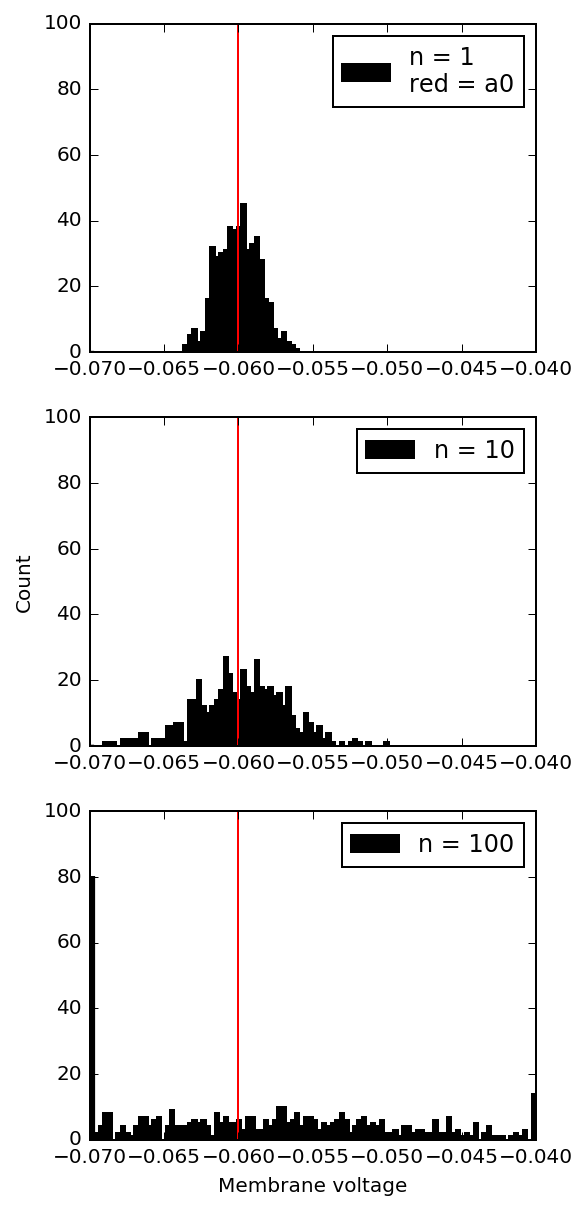

In [4]:
# Params
a0 = -0.06
ns = [2, 10, 100]
js = range(500)
sigma_l = 0.01 / 10  # small
sigma_b = 0.01 / 1000  # tiny (APs are stereotyped!)

# Run, saving in res indexed by `n`.
res = {}
for n in ns:
    res[n] = [axon(a0, n, sigma_l, sigma_b)[-1] for j in js]
    
# Plot
plt.figure(figsize=(4,10))

hieght = 100
plt.subplot(311)
plt.hist(res[2], color="k", label="n = 1\nred = a0", bins=100, range=(-0.07, -0.04))
plt.vlines(a0, 0, 30)
plt.xlim(-0.07, -0.04)
plt.vlines(a0, 0, hieght, color='r')
plt.ylim(0, hieght)
plt.legend()

plt.subplot(312)
plt.hist(res[10], color="k", label="n = 10", bins=100, range=(-0.07, -0.04))
plt.vlines(a0, 0, 30)
plt.xlim(-0.07, -0.04)
plt.vlines(a0, 0, hieght, color='r')
plt.ylim(0, hieght)
plt.ylabel("Count")
plt.legend()


plt.subplot(313)
plt.hist(res[100], color="k", label="n = 100", bins=100, range=(-0.07, -0.04))
plt.vlines(a0, 0, hieght, color='r')
plt.xlim(-0.07, -0.04)
plt.ylim(0, hieght)
plt.xlabel("Membrane voltage")
plt.legend()

In a biologically constrained parameterization Tee's effect holds up perfectly.

## FORCE

FORCE is a variant 'liquid state machine' or 'echo state machine' supervised learning system, that can tame chaotic patterns to match a target. Here's an classic example of FORCE wherein firing rates represent real values.

Neurons here are replaced `units`, or neural mass models that represent the aggregrate firing rates of many neurons. This is a common, and useful, theoretical abstraction, in case you're not familiar with it.

### Neural masses

We simulate the model:

$$\frac{d\mathbf{x}}{dt} = -\mathbf{x} + g J \tanh{[\mathbf{x}]} $$

with $x \in \mathcal{R}^N$ (vector), $J \in \mathcal{R}^{N \times N}$ (matrix), $g \in \mathcal{R}$ (scalar). Randomly draw each element of $J$ from a Gaussian distribution with zero mean and variance $1/N$. Characterize the output of the system for increasing values of $g$. If $g$ is greater than 1.5 the system will behave chaotically. If you take $g$ = 1 it reduces the system from FORCE to a tradtional 'echo state' system.

* Here's an example of what the firing of 10 random units looks like:

Neural masses can encode:
* Voltage
* Firing rate
* Conductance

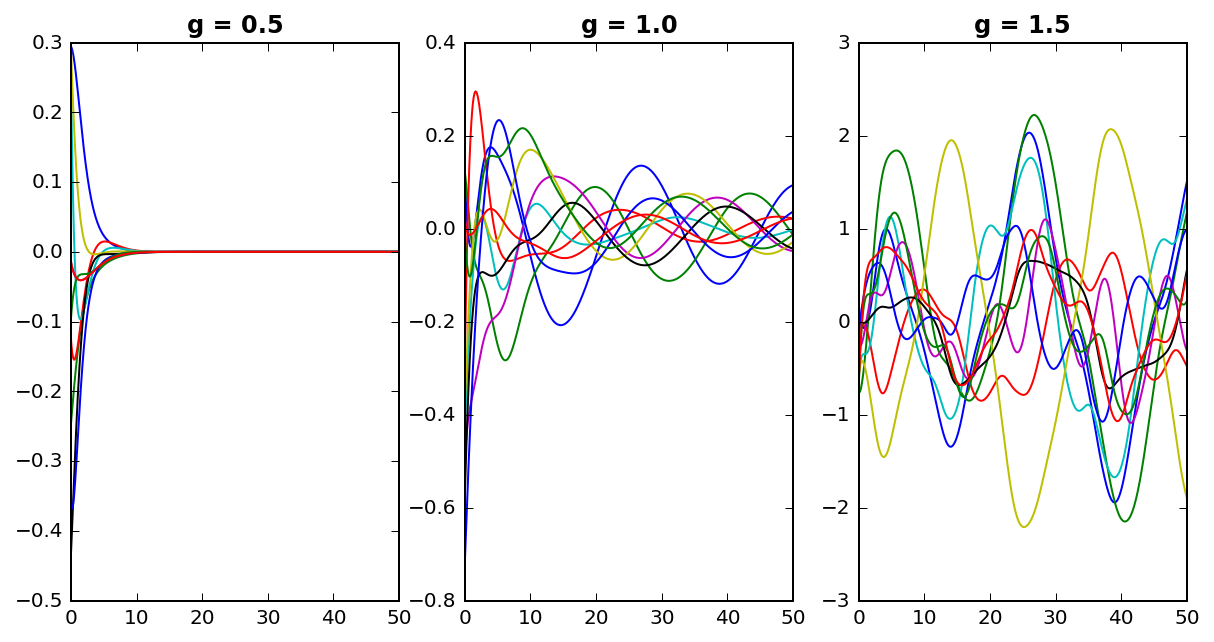

In [5]:
def f1(x,t0):
    return -x + g*dot(J,tanh(x))

N = 100
J = normal(0,sqrt(1/N),(N,N))
x0 = uniform(-0.8,0.3,N)
t = linspace(0,50,1000)

plt.figure(figsize=(10,5))
for s,g in enumerate(linspace(0.5,1.5,3)):
    plt.subplot(1,3,s+1)
    x = odeint(f1,x0,t)
    plt.plot(t,x[:,choice(N,10)])
    plt.title('g = '+str(g),fontweight='bold')
plt.show()

In [6]:
x.shape

(1000, 100)

#### The loss function

You can linearly reweight the chaos into doing very useful computation. We call this learner the readout readout unit.

Model an output or readout unit for the network as:

$$z = \mathbf{w}^T \tanh[\mathbf{x}]$$

The output $z$ is a scalar formed by the dot product of two N-dimensional vectors ($\mathbf{w}^T$ denotes the transpose of $\mathbf{w}$). We will implement the FORCE learning rule [(Susillo & Abbott, 2009)](http://dx.doi.org/10.1016/j.neuron.2009.07.018), by adjusting the readout weights, $w_i$, so that $z$ matches a target function:

$$f(t) = \cos\left(\frac{2 \pi t}{50} \right)$$

The rule works by implementing [recursive least-squares](https://www.youtube.com/watch?v=gHSiFqO23TE):

$$\mathbf{w} \rightarrow \mathbf{w} + c(f-z) \mathbf{q}$$

$$\mathbf{q} = P \tanh [\mathbf{x}]$$

$$c = \frac{1}{1+ \mathbf{q}^T \tanh(\mathbf{x})}$$

$$P_{ij} \rightarrow P_{ij} - c q_i q_j$$

### Real FORCE

Let's teach the chaos how to be a sin wave

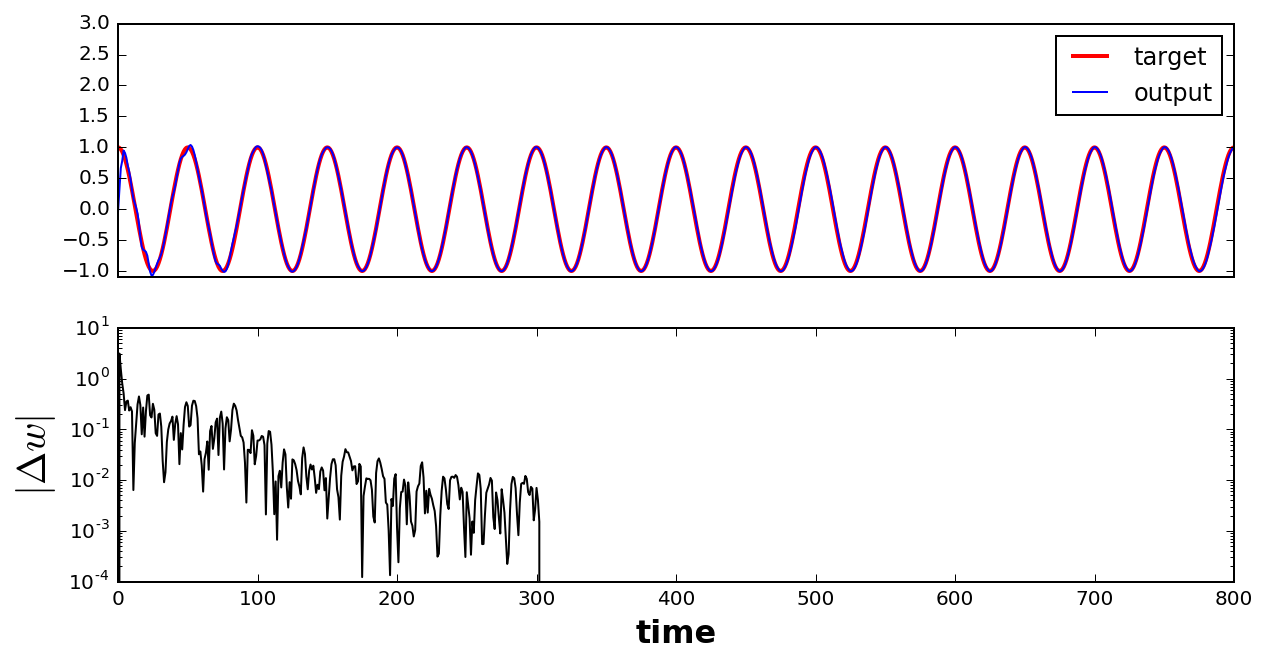

In [7]:
target = lambda t0: cos(2 * pi * t0 / 50) # target pattern

def f3(t0, x):
    return -x + g * dot(J, tanh_x) + dot(w, tanh_x) * u

dt = 1       # time step
tmax = 800   # simulation length
tstop = 300

N = 300
J = normal(0, sqrt(1 / N), (N, N))
x0 = uniform(-0.5, 0.5, N)
t = linspace(0, 50, 500)

g = 1.5
u = uniform(-1, 1, N)
w = uniform(-1 / sqrt(N), 1 / sqrt(N), N)  # initial weights
P = eye(N)  # Running estimate of the inverse correlation matrix
lr = 1.0  # learning rate

# simulation data: state, output, time, weight updates
x, z, t, wu = [x0], [], [0], [0]

# response stats
x_stats = []

# Set up ode solver
solver = ode(f3)
solver.set_initial_value(x0)

# Integrate ode, update weights, repeat
while t[-1] < tmax:
    tanh_x = tanh(x[-1])  # cache
    z.append(dot(w, tanh_x))
    error = target(t[-1]) - z[-1]
    q = dot(P, tanh_x)
    c = lr / (1 + dot(q, tanh_x))
    P = P - c * outer(q, q)
    w = w + c * error * q

    # Stop leaning here
    if t[-1] > tstop:
        lr = 0

    wu.append(np.sum(np.abs(c * error * q)))

    solver.integrate(solver.t + dt)
    res = solver.y
    x.append(res)
    x_stats.append([np.min(res), np.max(res), np.mean(res), np.var(res)])
    t.append(solver.t)

# last update for readout neuron
z.append(dot(w, tanh_x))

x = np.array(x)
t = np.array(t)

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(t, target(t), '-r', lw=2)
plt.plot(t, z, '-b')
plt.legend(('target', 'output'))
plt.ylim([-1.1, 3])
plt.xticks([])
plt.subplot(2, 1, 2)
plt.plot(t, wu, '-k')
plt.yscale('log')
plt.ylabel('$|\Delta w|$', fontsize=20)
plt.xlabel('time', fontweight='bold', fontsize=16)
plt.show()

x_stats = np.array(x_stats).T

FORCE does a pretty nice job learning how to be a sin wave. If you rerun this a few times, you'll see the quality of the fits varies. Such if woring with randomness and chaos.

MEAN of Statistics:
Min  [ x(t) ] = -2.9617 
Max  [ x(t) ] = 2.9666 
Mean [ x(t) ] = 0.0015 
Var  [ x(t) ] = 1.0149 


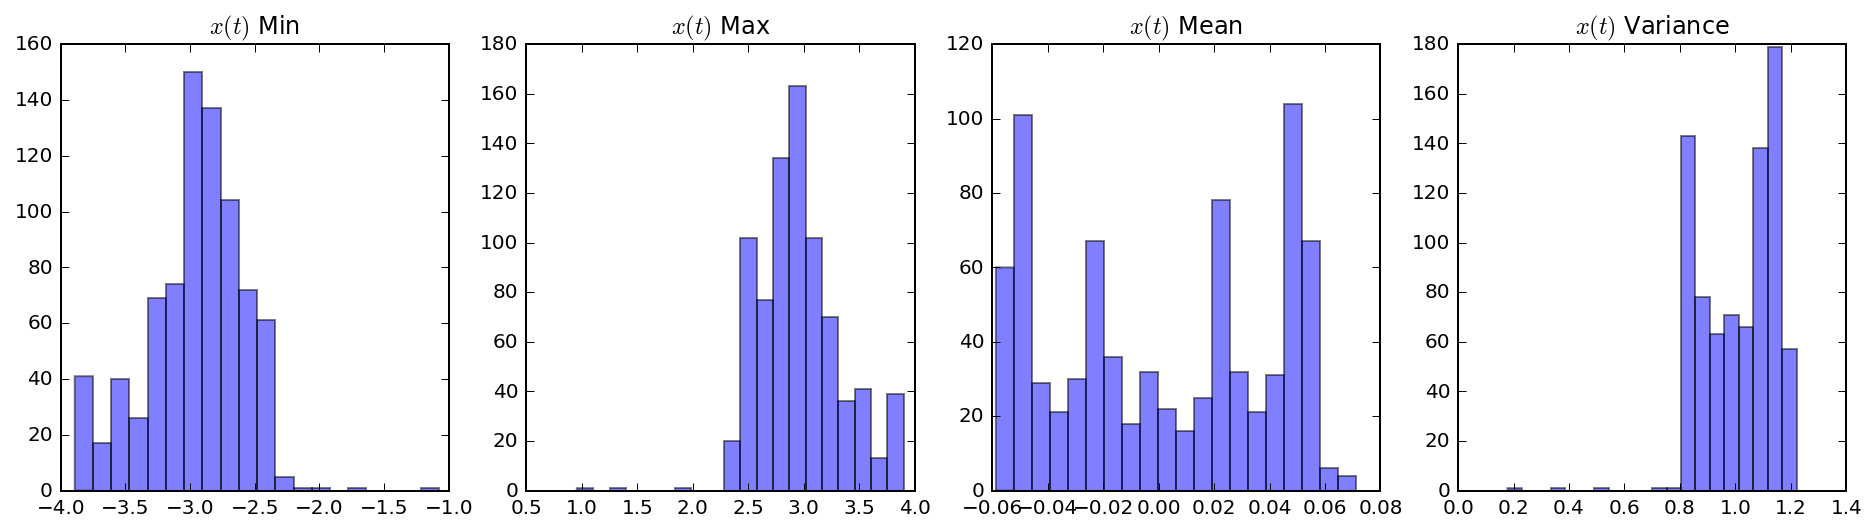

In [11]:
# X(t) Reponse Stats
plt.figure(figsize=(16, 4))
plt.subplot(1,4,1)
plt.hist(x_stats[0], bins=20, alpha=.5)
plt.title(r'$x(t)$ Min')
plt.subplot(1,4,2)
plt.hist(x_stats[1], bins=20, alpha=.5)
plt.title(r'$x(t)$ Max')
plt.subplot(1,4,3)
plt.hist(x_stats[2], bins=20, alpha=.5)
plt.title(r'$x(t)$ Mean');
plt.subplot(1,4,4)
plt.hist(x_stats[3], bins=20, alpha=.5)
plt.title(r'$x(t)$ Variance');

print ("MEAN of Statistics:")
print ("Min  [ x(t) ] = %.4f " % np.mean(x_stats[0]))
print ("Max  [ x(t) ] = %.4f " % np.mean(x_stats[1]))
print ("Mean [ x(t) ] = %.4f " % np.mean(x_stats[2]))
print ("Var  [ x(t) ] = %.4f " % np.mean(x_stats[3]))


### Binary FORCE

#### Implementation

I first define a function that converts unit rates into a binary output. Then I replace the standard learning FORCE math to use the binary decoded response generated by this function.

In [92]:
def decode(x, rho):
    xd = zeros_like(x)
    
    xd[x > rho] = 1
    xd[x < -rho] = -1
    
    return xd

* Here's when the binary version looks like. I use random (`U`) selected thresholds to convert from rates to binary codes. Don't have any idea how this really works, so random seems as good a guess as any.

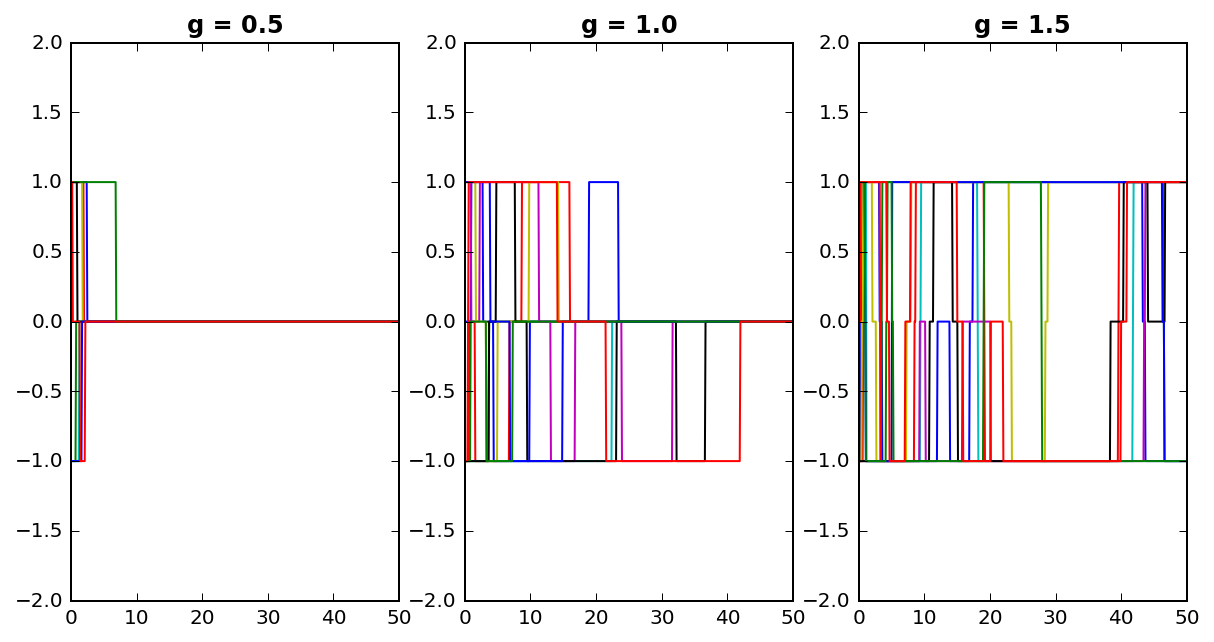

In [93]:
def f1(x,t0):
    return -x + g*dot(J,tanh(x))

N = 500
J = normal(0,sqrt(1/N),(N,N))
x0 = uniform(-0.5,0.5,N)
t = linspace(0,50,500)

rho = uniform(0,0.1,N)  # Rand thresholds!

plt.figure(figsize=(10,5))
for s,g in enumerate(linspace(0.5,1.5,3)):
    plt.subplot(1,3,s+1)
    x = odeint(f1,x0,t)
    xd = decode(x, rho)
    plt.plot(t,xd[:,choice(N,10)])
    plt.title('g = '+str(g),fontweight='bold')
    plt.ylim(-2,2)
plt.show()

#### The binary loss function

Now let's learn, with binary codes.

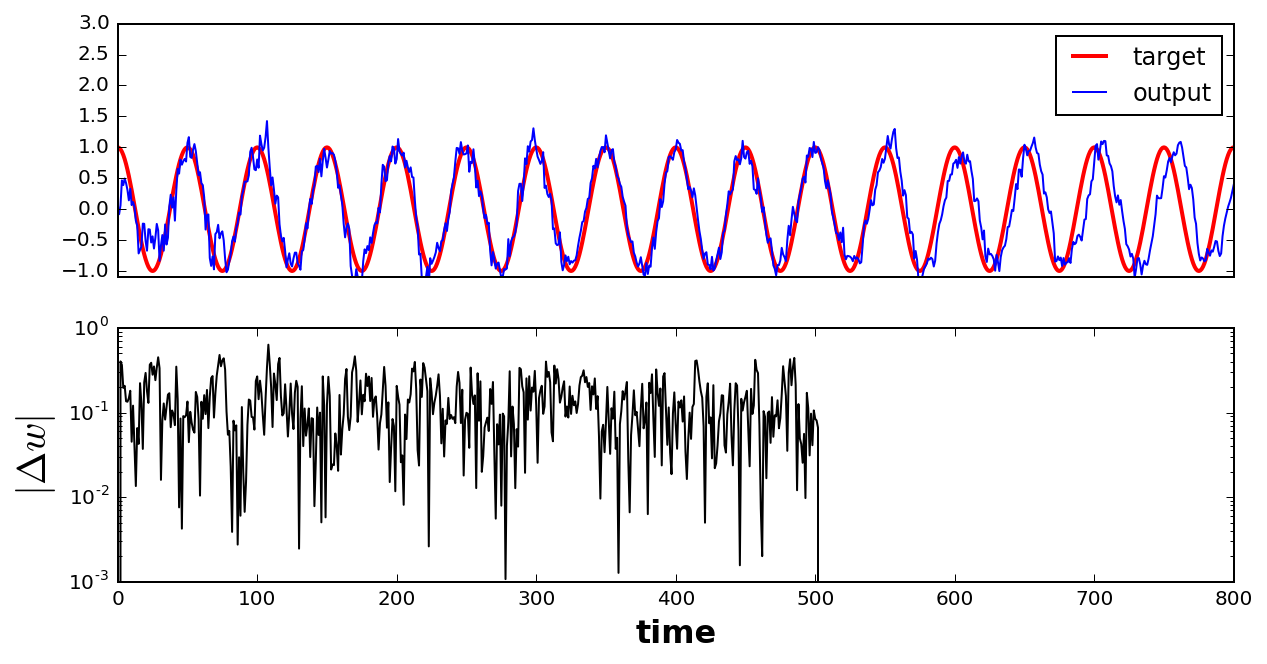

In [126]:
target = lambda t0: cos(2 * pi * t0 / 50)  # target pattern


def f3(t0, x):
    return -x + g * dot(J, tanh_x) + dot(w, tanh_x) * u

dt = 1       # time step
tmax = 800   # simulation length
tstop = 500

N = 300
J = normal(0, sqrt(1 / N), (N, N))
x0 = uniform(-0.5, 0.5, N)
t = linspace(0, 50, 500)

rho = 0.1  # Set and rand vec
rho = uniform(0, 0.5, N)

g = 1.5
u = uniform(-1, 1, N)
w = uniform(-1 / sqrt(N), 1 / sqrt(N), N)  # initial weights
P = eye(N)  # Running estimate of the inverse correlation matrix
lr = .4  # learning rate

rho = repeat(.5, N)

# simulation data: state,
# output, time, weight updates
x, z, t, wu = [x0], [], [0], [0]

# Set up ode solver
solver = ode(f3)
solver.set_initial_value(x0)

# Integrate ode, update weights, repeat
while t[-1] < tmax:
    tanh_x = tanh(x[-1])
    tanh_xd = decode(tanh_x, rho)  # BINARY CODE INTRODUCED HERE!
    z.append(dot(w, tanh_xd))

    error = target(t[-1]) - z[-1]
    q = dot(P, tanh_xd)
    c = lr / (1 + dot(q, tanh_xd))
    P = P - c * outer(q, q)
    w = w + c * error * q

    # Stop training time
    if t[-1] > tstop:
        lr = 0

    wu.append(np.sum(np.abs(c * error * q)))

    solver.integrate(solver.t + dt)
    x.append(solver.y)
    t.append(solver.t)

# last update for readout neuron
z.append(dot(w, tanh_x))

# plot
x = np.array(x)
t = np.array(t)

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(t, target(t), '-r', lw=2)
plt.plot(t, z, '-b')
plt.legend(('target', 'output'))
plt.ylim([-1.1, 3])
plt.xticks([])
plt.subplot(2, 1, 2)
plt.plot(t, wu, '-k')
plt.yscale('log')
plt.ylabel('$|\Delta w|$', fontsize=20)
plt.xlabel('time', fontweight='bold', fontsize=16)
plt.show()

* Besides some small fluctations, the binary version does nearly as well as the real valued version above!
* I need to quantify performance differences between the two models and,
* need to train with many more kinds of inputs to be sure but
* I think with your axon part and my FORCE part could really work nicely toghether in a short published report. Not sure where, or if, you are along in the publication process. But if you're interested in a joint thing, let me know.

In [1]:
repeat?

Object `repeat` not found.
